In [1]:
import numpy as np
import os
from itertools import islice
import matplotlib.pyplot as plt
from operator import itemgetter

In [2]:
def get_words(f):
    return f.readline().split()

def read_from_file(file):
    with open(file, "r") as f:
        title = get_words(f)[1:]
        get_words(f)
        message = get_words(f)
        return title + message, int("legit" in file)

In [3]:
def read_from_directory(dirname):
    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, file))]
    return list(map(read_from_file, files))

In [4]:
def read_dataset():
    return [read_from_directory("data/part" + str(i)) for i in range(1, 11)]      

In [5]:
dataset = read_dataset()

In [6]:
# From examples https://docs.python.org/release/2.3.5/lib/itertools-example.html
def window(seq, n):
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [7]:
class BayesClassificator():
    def __init__(self, alpha, n, lambdas=[1e100, 1e100]):
        self.class_count = [0, 0]
        self.class_count_words = [{}, {}]
        self.all_words = {}
        self.initial_ans = [np.longdouble(0), np.longdouble(0)]
        self.alpha = alpha
        self.n = n
        self.lambdas = lambdas
    
    def inc_letter(self, letter, cl):
        words = {}
        for w in window(letter, self.n):
            self.all_words[w] = True
            if w in words:
                continue
            words[w] = True
            if w not in self.class_count_words[cl]:
                self.class_count_words[cl][w] = 0
            self.class_count_words[cl][w] += 1
        self.class_count[cl] += 1
    
    def word_prob(self, cl, word, reverse):
        if word in self.class_count_words[cl]:
            cnt = self.class_count_words[cl][word]
        else:
            cnt = 0
        if reverse:
            cnt = self.class_count[cl] - cnt
        return np.longdouble(cnt + self.alpha) / np.longdouble((2 * self.alpha + self.class_count[cl]))
        
    def calc_initial_ans(self):
        for i in range(0, 2):
            self.initial_ans[i] = self.class_count[i] / (self.class_count[0] + self.class_count[1])
            self.initial_ans[i] *= self.lambdas[i]
            self.initial_ans[i] = np.longdouble(self.initial_ans[i])
            for j in self.all_words:
                self.initial_ans[i] *= self.word_prob(i, j, True)
    
    def letter_class(self, letter):
        ans = self.initial_ans.copy()
        words = {}
        for w in window(letter, self.n):
            if w in words:
                continue
            words[w] = True
            if w not in self.all_words:
                continue
            for i in range(0, 2):
                ans[i] /= self.word_prob(i, w, True)
                ans[i] *= self.word_prob(i, w, False)
        return ans

In [8]:
def get_stat():
    alphas = [10 ** (-i) for i in range(95, 105)]
    stat = []
    for n in [1, 2, 3]:
        for a in alphas:
            total = 0
            cnt = 0
            for i in range(0, 10):
                b = BayesClassificator(a, n)
                for ii in range(0, 10):
                    if ii == i:
                        continue
                    for j in dataset[ii]:
                        b.inc_letter(j[0], j[1])
                b.calc_initial_ans()
                for j in dataset[i]:
                    let_class = b.letter_class(j[0])
                    let_class = 0 if let_class[0] > let_class[1] else 1
                    cnt += int(let_class == j[1])
                    total += 1
            acc = cnt / total
            stat.append({ "alpha": a, "n": n, "accuracy": acc })
    return stat

In [9]:
# ROC

def roc(alpha, n, lambdas):
    b = BayesClassificator(alpha, n, lambdas)
    for i in range(0, 10):
        for j in dataset[i]:
            b.inc_letter(j[0], j[1])
    b.calc_initial_ans()
    src = []
    for i in range(0, 10):
        for j in dataset[i]:
            src.append((b.letter_class(j[0])[0], j[1]))
    src = sorted(src, key=itemgetter(0))
    m = 0
    n = 0
    for i in src:
        if i[1] == 0:
            m += 1
        else:
            n += 1
    x = []
    y = []
    cur_x = 0.0
    cur_y = 0.0
    for i in src:
        if i[1] == 0:
            cur_x += 1.0 / m
        else:
            cur_y += 1.0 / n
        x.append(cur_x)
        y.append(cur_y)
    plt.figure(figsize=(5, 5))
    plt.plot(x, y)
    plt.plot([0.0, 1.0], [0.0, 1.0])
    plt.show()


In [10]:
stat = get_stat()

In [14]:
for i in stat:
    print(i)

{'alpha': 1e-95, 'n': 1, 'accuracy': 0.9669724770642202}
{'alpha': 1e-96, 'n': 1, 'accuracy': 0.9669724770642202}
{'alpha': 1e-97, 'n': 1, 'accuracy': 0.9669724770642202}
{'alpha': 1e-98, 'n': 1, 'accuracy': 0.9669724770642202}
{'alpha': 1e-99, 'n': 1, 'accuracy': 0.9669724770642202}
{'alpha': 1e-100, 'n': 1, 'accuracy': 0.9669724770642202}
{'alpha': 1e-101, 'n': 1, 'accuracy': 0.9660550458715597}
{'alpha': 1e-102, 'n': 1, 'accuracy': 0.9660550458715597}
{'alpha': 1e-103, 'n': 1, 'accuracy': 0.9660550458715597}
{'alpha': 1e-104, 'n': 1, 'accuracy': 0.9651376146788991}
{'alpha': 1e-95, 'n': 2, 'accuracy': 0.9431192660550459}
{'alpha': 1e-96, 'n': 2, 'accuracy': 0.9431192660550459}
{'alpha': 1e-97, 'n': 2, 'accuracy': 0.9431192660550459}
{'alpha': 1e-98, 'n': 2, 'accuracy': 0.9422018348623853}
{'alpha': 1e-99, 'n': 2, 'accuracy': 0.9412844036697248}
{'alpha': 1e-100, 'n': 2, 'accuracy': 0.9412844036697248}
{'alpha': 1e-101, 'n': 2, 'accuracy': 0.9403669724770642}
{'alpha': 1e-102, 'n': 2

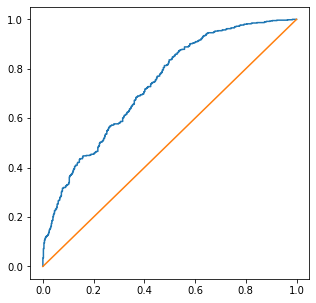

In [74]:
roc(1e-5, 1, [1e100, 1e100])

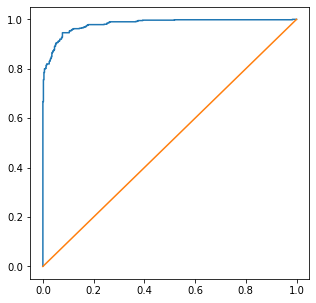

In [75]:
roc(1e-95, 1, [1e100, 1e100])

In [148]:
def l_graph(alpha, init, lambds):
    x = []
    y = []
    for s in range(len(lambds)):
        l = lambds[s]
        b = BayesClassificator(alpha, 1, [l, init])
        for i in range(0, 10):
            for j in dataset[i]:
                b.inc_letter(j[0], j[1])
        b.calc_initial_ans()
        src = []
        cnt = 0
        total = 0
        for i in range(0, 10):
            for j in dataset[i]:
                let_class = b.letter_class(j[0])
                let_class = 0 if let_class[0] > let_class[1] else 1
                cnt += int(let_class == j[1])
                total += 1
        x.append(s)
        y.append(cnt / total)
    plt.plot(x, y)
    plt.show()

In [77]:
def all_legit_correct(alpha, lambdas):
    b = BayesClassificator(alpha, 1, lambdas)
    for i in range(0, 10):
        for j in dataset[i]:
            b.inc_letter(j[0], j[1])
    b.calc_initial_ans()
    for i in range(0, 10):
        for j in dataset[i]:
            let_class = b.letter_class(j[0])
            let_class = 0 if let_class[0] > let_class[1] else 1
            if let_class != j[1] and j[1] == 1:
                return False
    return True

In [140]:
print(all_legit_correct(1, [1, 1]))
print(all_legit_correct(1, [1, 1e100]))

False
True


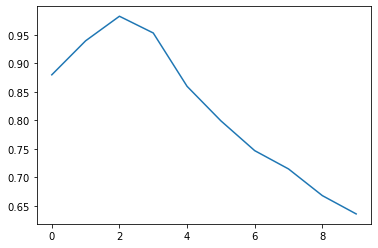

In [150]:
l_graph(1, 1e10, [10 ** i for i in range(0, 100, 10)])